# Run TensorFlow on CPU, GPU and TPU

<!-- This tag adds target="_blank" to every link the page -->
<base target="_blank">

This CoLab runs TensorFlow MobileNet V1, V2 and V3 on CPU, GPU and NPU (TPU) devices. Or at least try to run.

* [Selflink](https://colab.research.google.com/drive/1fRB3-xYYJt6n2yDAysDxpwzifiAIAbNq)
* [This Coral TPU project](https://github.com/foobar167/junkyard/tree/master/coral_tpu)

Useful links:
   * [Keras image classificaiton](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
   * [MobileNet V1, V2 and V3](https://keras.io/api/applications/mobilenet/)
   * [Satellite land cover and land use classification](https://www.kaggle.com/code/nikhil123123/satellite-land-cover-and-land-use-classification)
   * [Сonvert TF saved model to TFLite](https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter)
   * [TensorFlow models on the Edge TPU](https://coral.ai/docs/edgetpu/models-intro/#compatibility-overview)
   * [TensorFlow Lite: TFLite Model Optimization for On-Device Machine Learning](https://learnopencv.com/tensorflow-lite-model-optimization-for-on-device-machine-learning/)


## Helper functions

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
import os
import math
import json
import shutil
import zipfile
import tarfile
import platform

from PIL import Image
from matplotlib import pyplot as plt


def extract(fname):
    """ Extract data from archive file """
    if fname.endswith(".tar.gz") or fname.endswith(".tgz"):
        ref = tarfile.open(fname, mode="r:gz")
    elif fname.endswith(".tar"):
        ref = tarfile.open(fname, mode="r:")
    elif fname.endswith(".tar.bz2") or fname.endswith(".tbz"):
        ref = tarfile.open(fname, mode="r:bz2")
    elif fname.endswith(".zip"):
        ref = zipfile.ZipFile(fname, mode="r")
    ref.extractall()
    ref.close()


def tgz(sdir):
    """ Make *.tgz archive file from source dir """
    sdir = sdir.strip("\\/")  # remove all leading and trailing slashes
    fname = os.path.basename(sdir)
    fname_tgz = fname + ".tgz"
    fname_tar_gz = fname + ".tar.gz"
    archive1 = os.path.join(os.path.dirname(sdir), fname_tgz)
    archive2 = os.path.join(os.path.dirname(sdir), fname_tar_gz)
    # Delete dir or file if exists
    if os.path.exists(archive1) and os.path.isdir(archive1):
        shutil.rmtree(archive1, ignore_errors=False)
    elif os.path.exists(archive1) and os.path.isfile(archive1):
        os.remove(archive1)
    # Make *.tag.gz file
    with tarfile.open(fname_tar_gz, "w:gz") as tar:
        tar.add(sdir, arcname=fname)
    # Reaneme *.tar.gz to *.tgz
    os.rename(archive2, archive1)


EXT = (".jpg", ".jpeg", ".png", ".gif")  # valid image file extensions


def separator(info=""):
    """ Separator string with information """
    sep1 = "-"
    sep2 = " "
    sep_length = 70  # separator length
    l1 = (sep_length - len(info)) // 2 - len(sep2)  # number of dashes
    if len(info) == 0:
        s = sep1 * sep_length
        return f"{s}"
    elif l1 <= 0:
        return info
    else:
        l2 = (sep_length - len(info)) % 2  # 0 or 1 extra space
        s1 = sep1 * l1
        s2 = info + " " * l2
        return f"{s1}{sep2}{s2}{sep2}{s1}"


def get_image_names(path):
    """ Get all image names in a directory """
    names = []
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            names.append(f)
    return names


def get_images(path):
    """ Get all images in a directory """
    images = {}
    for f in os.listdir(path):
        if f.lower().endswith(EXT):
            images[f] = Image.open(os.path.join(path, f)).convert("RGB")
    return images


def show(images, cmap="viridis"):
    """ Show images with matplotlib. Default color map is "viridis" """
    fig = plt.figure(figsize=(12, 8))  # create figure
    l = len(images)
    rows = math.floor(math.sqrt(l))
    cols = math.ceil(l / rows)
    for i, (key, value) in enumerate(images.items(), 1):
        fig.add_subplot(rows, cols, i)  # add a subplot
        plt.imshow(value, cmap=cmap); plt.axis("off"); plt.title(key)
    plt.show()


def load_labels(idx=1):
    """ Get ImageNet dataset labels from URL """
    url = "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/data/imagenet_class_index.json"
    name = os.path.basename(url)
    if not os.path.exists(name):
        output = os.system(f"wget {url} -O {name}")
        if output != 0:
            print(f"Error when downloading URL: {url}")
            return None
    CLASS_INDEX = json.load(open(name))
    labels = []
    for i in range(len(CLASS_INDEX)):
        # CLASS_INDEX example: "753": ["n04040759", "radiator"]
        labels.append(CLASS_INDEX[str(i)][idx])
    return labels


_INFO = {
    "Linux": "lscpu | grep 'Model name:'",
    "Windows": "wmic cpu get name, numberofcores",
}[platform.system()]


print(separator("CPU info"))
print(os.popen(cmd=_INFO).read())  # get info about the hardware (CPU)

------------------------------ CPU info ------------------------------
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz



## Predict ImageNet classes with MobileNet v1, v2 and v3

Take six different MobileNet versions for [ImageNet](https://www.image-net.org/) dataset with parameters `alpha=1.0` and `input_shape=(224,224)`:
   * [v1](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/MobileNet)
   * [v2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/MobileNetV2)
   * [v3_large](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Large)
   * **v3_large_min** with parameter `minimalistic=True`
   * [v3_small](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV3Small)
   * **v3_small_min** with parameter `minimalistic=True`

parrot.jpg
human.jpg
panda.jpg
cat.jpg


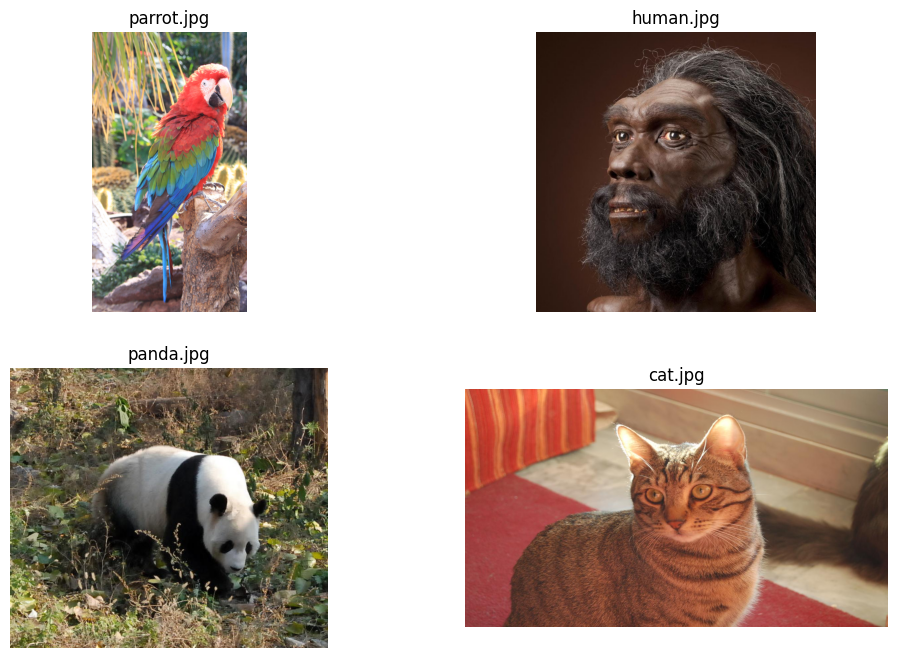

In [ ]:
# Import necessary libraries
import time
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.applications as apps

from IPython.display import display
from tensorflow.keras.saving import save_model, load_model


# Create "temp" directory and make it the current dir
temp_dir = "temp"
this_dir = os.path.dirname(os.path.realpath("__file__"))  # path to the current dir
if os.path.basename(this_dir) == temp_dir:  # already in the "temp" directory
    pass
else:
    if not os.path.isdir(temp_dir):  # directory does not exist
        os.makedirs(temp_dir)
    os.chdir(os.path.join(this_dir, temp_dir))  # make path to "temp" dir the current path


# Download test images and show them
urls = {"parrot.jpg": "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/data/parrot.jpg",
        "cat.jpg": "https://raw.githubusercontent.com/foobar167/junkyard/master/coral_tpu/data/cat_720p.jpg",
        "panda.jpg": "https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG",
        "human.jpg": "https://miro.medium.com/v2/resize:fit:835/1*1ZqPKQFcHehTR24TgYcGlQ.jpeg",
}
img_paths = []
for name, url in urls.items():
    output = os.system(f"wget {url} -O {name}")
    if output == 0:
        img_paths.append(name)
    else:
        print(f"Error when downloading URL: {url}")
print("\n".join(get_image_names(".")))  # print image names
show(get_images("."))  # show images


# Set constants
BATCH_SIZE = 100
IMAGE_SHAPE = (224, 224, 3)  # do not change it
RESIZE_METHOD = Image.BILINEAR
RESIZE_METHOD2 = tf.image.ResizeMethod.BILINEAR
BENCHMARK_IMG = "parrot.jpg"
COUNT = 22  # number of runs for benchmark
TOP_K = 3  # get first top results
OPTIMIZER = "rmsprop"
LOSS = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
METRICS = ["accuracy"]


# MobileNet models dictionary in the format:
#     key: [name, model, api, results]
mobilenet = {
    "v1": ["mobilenet_v1_1.0_224", apps.MobileNet(), apps.mobilenet, ""],
    "v2": ["mobilenet_v2_1.0_224", apps.MobileNetV2(), apps.mobilenet_v2, ""],
    "v3_large":
        ["mobilenet_v3_large_1.0_224",
        apps.MobileNetV3Large(input_shape=IMAGE_SHAPE),
        apps.mobilenet_v3, ""],
    "v3_large_min":
        ["mobilenet_v3_large_minimalistic_1.0_224",
        apps.MobileNetV3Large(input_shape=IMAGE_SHAPE, minimalistic=True),
        apps.mobilenet_v3, ""],
    "v3_small":
        ["mobilenet_v3_small_1.0_224",
        apps.MobileNetV3Small(input_shape=IMAGE_SHAPE),
        apps.mobilenet_v3, ""],
    "v3_small_min":
        ["mobilenet_v3_small_minimalistic_1.0_224",
        apps.MobileNetV3Small(input_shape=IMAGE_SHAPE, minimalistic=True),
        apps.mobilenet_v3, ""],
}

Predictions for 'parrot.jpg' image are:

    v1           [('macaw', '0.9998'), ('bee_eater', '0.0001'), ('lorikeet', '0.0001')]
    v2           [('macaw', '0.9413'), ('lorikeet', '0.0059'), ('bee_eater', '0.0024')]
    v3_large     [('macaw', '0.9773'), ('bee_eater', '0.0018'), ('lorikeet', '0.0011')]
    v3_large_min [('macaw', '0.8175'), ('cock', '0.0064'), ('lorikeet', '0.0036')]
    v3_small     [('macaw', '0.7953'), ('bee_eater', '0.1064'), ('lorikeet', '0.0069')]
    v3_small_min [('macaw', '0.8783'), ('bee_eater', '0.0175'), ('lorikeet', '0.0092')]

Predictions for 'cat.jpg' image are:

    v1           [('Egyptian_cat', '0.8436'), ('tiger_cat', '0.0781'), ('tabby', '0.0746')]
    v2           [('Egyptian_cat', '0.6831'), ('tabby', '0.1041'), ('tiger_cat', '0.0678')]
    v3_large     [('tiger_cat', '0.4392'), ('tabby', '0.1746'), ('Egyptian_cat', '0.1084')]
    v3_large_min [('Egyptian_cat', '0.4949'), ('tabby', '0.1941'), ('tiger_cat', '0.0929')]
    v3_small     [('Egyptian_cat', '0.3859'), ('tiger_cat', '0.3096'), ('tabby', '0.0808')]
    v3_small_min [('tabby', '0.4214'), ('Egyptian_cat', '0.2769'), ('tiger_cat', '0.1684')]

Predictions for 'panda.jpg' image are:

    v1           [('giant_panda', '0.9987'), ('Arctic_fox', '0.0003'), ('white_wolf', '0.0002')]
    v2           [('giant_panda', '0.9263'), ('hog', '0.0012'), ('ice_bear', '0.0011')]
    v3_large     [('giant_panda', '0.9493'), ('ice_bear', '0.0018'), ('lesser_panda', '0.0013')]
    v3_large_min [('giant_panda', '0.8763'), ('hog', '0.0068'), ('albatross', '0.0050')]
    v3_small     [('giant_panda', '0.9058'), ('hog', '0.0161'), ('badger', '0.0049')]
    v3_small_min [('giant_panda', '0.7761'), ('Arctic_fox', '0.0257'), ('Great_Pyrenees', '0.0155')]

Predictions for 'human.jpg' image are:

    v1           [('titi', '0.1984'), ('guenon', '0.1171'), ('macaque', '0.1054')]
    v2           [('chimpanzee', '0.4641'), ('macaque', '0.0344'), ('orangutan', '0.0283')]
    v3_large     [('chimpanzee', '0.2741'), ('wig', '0.0411'), ('oboe', '0.0296')]
    v3_large_min [('chimpanzee', '0.2064'), ('wig', '0.0699'), ('macaque', '0.0434')]
    v3_small     [('chimpanzee', '0.7489'), ('titi', '0.0441'), ('marmoset', '0.0272')]
    v3_small_min [('chimpanzee', '0.1639'), ('marmoset', '0.1025'), ('wig', '0.0837')]


View tables from chapter [Estimate accuracy and speed on ImageNet-v2 dataset](#scrollTo=Pos-k0cVcpWf)
with average data on 10000 images.


In [ ]:
def prepare_image(img_path, preprocess_input):
    """ Prepare image for the model """
    # interpolation="lanczos" is better than default "nearest"
    img = Image.open(img_path).resize(IMAGE_SHAPE[0:2], RESIZE_METHOD)
    img = np.asarray(img)
    img = preprocess_input(img)
    # plt.imshow(img); plt.show()  # show image if necessary
    img = np.expand_dims(img, axis=0)
    return img


def predict(img, model, decode_predictions):
    """ Predict and decode results """
    # Use "model(img)" instead of "model.predict(img)", because
    # this code gets a retracing warning:
    #     "WARNING : tensorflow:5 out of the last 5 calls to..."
    preds = model(img, training=False).numpy()
    results = decode_predictions(preds, top=3)[0]
    # Return list of tuples (description, probability)
    return [(i[1], f"{i[2]:.4f}") for i in results]


# Predict images
for img_path in img_paths:
    # Prepare image and predict
    for k, v in mobilenet.items():
        img = prepare_image(img_path, v[2].preprocess_input)
        v[3] = predict(img, v[1], v[2].decode_predictions)

    # Show predicitons
    print(f"\n" f"Predictions for '{img_path}' image are:")
    for k, v in mobilenet.items():
        print(f"{k:12} {v[3]}")


Predictions for 'parrot.jpg' image are:
v1           [('macaw', '0.9998'), ('bee_eater', '0.0001'), ('lorikeet', '0.0001')]
v2           [('macaw', '0.9413'), ('lorikeet', '0.0059'), ('bee_eater', '0.0024')]
v3_large     [('macaw', '0.9773'), ('bee_eater', '0.0018'), ('lorikeet', '0.0011')]
v3_large_min [('macaw', '0.8175'), ('cock', '0.0064'), ('lorikeet', '0.0036')]
v3_small     [('macaw', '0.7953'), ('bee_eater', '0.1064'), ('lorikeet', '0.0069')]
v3_small_min [('macaw', '0.8783'), ('bee_eater', '0.0175'), ('lorikeet', '0.0092')]

Predictions for 'cat.jpg' image are:
v1           [('Egyptian_cat', '0.8436'), ('tiger_cat', '0.0781'), ('tabby', '0.0746')]
v2           [('Egyptian_cat', '0.6831'), ('tabby', '0.1041'), ('tiger_cat', '0.0678')]
v3_large     [('tiger_cat', '0.4392'), ('tabby', '0.1746'), ('Egyptian_cat', '0.1084')]
v3_large_min [('Egyptian_cat', '0.4949'), ('tabby', '0.1941'), ('tiger_cat', '0.0929')]
v3_small     [('Egyptian_cat', '0.3859'), ('tiger_cat', '0.3096'), ('t

## Run speed benchmarks for TF models

### Save TF models

In [ ]:
def save(model, name):
    """ Save model in *.tgz (tar.gz) archive file """
    # Set optimizer, loss and metrics for evaluation and warning supress
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    save_model(model, name)  # save model in a directory
    tgz(name)  # archive directory in *.tgz file, the same as *.tar.gz


for k, v in mobilenet.items():
    save(v[1], v[0])

Functions:
   * `tensorflow.keras.applications.mobilenet_v*.preprocess_input`
   * `tensorflow.keras.applications.mobilenet_v*.decode_predictions`

are convenient, but for TF Lite we have to implement them by hand.

In [ ]:
def preprocess_input(img_path, model_path):
    """ Preprocess input. Analogue of
        "tf.keras.applications.mobilenet_v*.preprocess_input" function """
    img = Image.open(img_path).resize(IMAGE_SHAPE[0:2], RESIZE_METHOD)
    img = np.asarray(img)  # convert from PIL Image to NumPy
    # Normalize or not
    if "_v1_" in model_path or "_v2_" in model_path:  # normalize
        img = img / 127.5 - 1.0
    elif "_v3_" in model_path:  # don't normalize
        pass
    else:  # don't normalize
        print("Warning: not a MobileNet model")
        pass
    img = np.expand_dims(img, axis=0)  # (224,224,3) to (1,224,224,3)
    return img


def decode_predictions(results):
    """ Decode predictions. Analogue of
        "tf.keras.applications.mobilenet_v*.decode_predictions" function """
    labels = load_labels()
    top = results.argsort()[-TOP_K:][::-1]  # get first top k results
    # Return list of tuples (label, probability)
    return [(labels[i], f"{results[i]:.4f}") for i in top]


def average_runtime(runtime):
    """ Show average runtime """
    if len(runtime) > 5:
        runtime = runtime[2:]  # skip the first 2 values
    elif len(runtime) > 1:
        runtime = runtime[1:]  # skip the 1st value
    average = f"{np.average(runtime):>6.1f} ms"
    print(f"Average time of the last {len(runtime)} runs: {average}")
    return average


def run_unconverted(img_path, model_path, unpack=True):
    """ Run unconverted TF model for image """
    if unpack:
        extract(model_path + ".tgz")  # extract from "*.tgz" archive
    model = load_model(model_path)  # load model
    print(separator("INFERENCE TIME"))
    img = preprocess_input(img_path, model_path)  # preprocess image
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        model(img, training=False)  # predict
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")
    print(separator("RESULTS"))
    results = model(img, training=False)  # predict
    del model
    results = results.numpy()[0]  # convert from tf to numpy
    print(decode_predictions(results))
    return average_runtime(runtime)


def benchmark(img_path, run):
    """ Run benchmarks """
    for k, v in mobilenet.items():
        print(f"\n{separator(v[0])}\n")
        v[3] = run(img_path=img_path, model_path=v[0])

    print(f"\n" f"Speeds for '{img_path}' image are:")
    for k, v in mobilenet.items():
        print(f"{k:12} {v[3]}")

In [ ]:
benchmark(BENCHMARK_IMG, run_unconverted)


------------------------ mobilenet_v1_1.0_224 ------------------------

--------------------------- INFERENCE TIME ---------------------------
170.6 ms
171.5 ms
175.0 ms
179.2 ms
188.2 ms
174.3 ms
163.7 ms
115.1 ms
118.5 ms
108.8 ms
127.9 ms
118.5 ms
110.0 ms
111.3 ms
112.0 ms
104.7 ms
112.8 ms
111.0 ms
117.8 ms
127.0 ms
113.4 ms
110.5 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9998'), ('bee_eater', '0.0001'), ('lorikeet', '0.0001')]
Average time of the last 20 runs:  130.0 ms

------------------------ mobilenet_v2_1.0_224 ------------------------

--------------------------- INFERENCE TIME ---------------------------
161.6 ms
314.0 ms
407.8 ms
434.9 ms
491.5 ms
535.0 ms
333.4 ms
296.7 ms
277.7 ms
288.7 ms
328.0 ms
331.3 ms
344.6 ms
355.3 ms
331.6 ms
284.0 ms
176.0 ms
239.1 ms
155.9 ms
269.7 ms
273.7 ms
307.1 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9413'), ('lorikeet', '0.0059'), ('bee_eater',

## Convert models to TensorFlow Lite (TFLite)

TFLite quantization useful links:
   * [Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)
   * [TFLite Model Optimization for On-Device Machine Learning](https://learnopencv.com/tensorflow-lite-model-optimization-for-on-device-machine-learning/)
   * [Model Quantization Methods In TensorFlow Lite](https://studymachinelearning.com/model-quantization-methods-in-tensorflow-lite/)
   * [StackOverflow. The correct way to create representative dataset for TFLiteConverter](https://stackoverflow.com/questions/57877959/what-is-the-correct-way-to-create-representative-dataset-for-tfliteconverter)


The `tf.lite.TFLiteConverter` class provides several options to customize the conversion process. Here are some of the most commonly used options:

   * `converter.optimizations`: This option enables various optimizations to reduce the model’s size and improve its performance. The available optimizations are `DEFAULT`, `OPTIMIZE_FOR_SIZE`, `OPTIMIZE_FOR_LATENCY`, and `OPTIMIZE_FOR_ACCURACY`.
   * `converter.experimental_new_converter`: This option enables the experimental new converter, which provides additional features and optimizations.
   * `converter.target_specifies`: This option specifies the target device and its capabilities, such as the CPU, GPU, or DSP. The available target specs are `tf.lite.TargetSpec.DEFAULT`, `tf.lite.TargetSpec.CPU`, `tf.lite.TargetSpec.GPU`, and `tf.lite.TargetSpec`.


Download the [ImageNet-v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2) dataset to test full integer quantization and perform final model evaluation.

Download Git [imagenet-sample-images](https://github.com/EliSchwartz/imagenet-sample-images): 1000 images, one random image per ImageNet class.
To make full integer quantization.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0.incompleteJAKI49/imagenet_v2-test.tfre…

Dataset imagenet_v2 downloaded and prepared to /root/tensorflow_datasets/imagenet_v2/matched-frequency/3.0.0. Subsequent calls will reuse this data.
Number of classes: 1000
Number of images: 10000


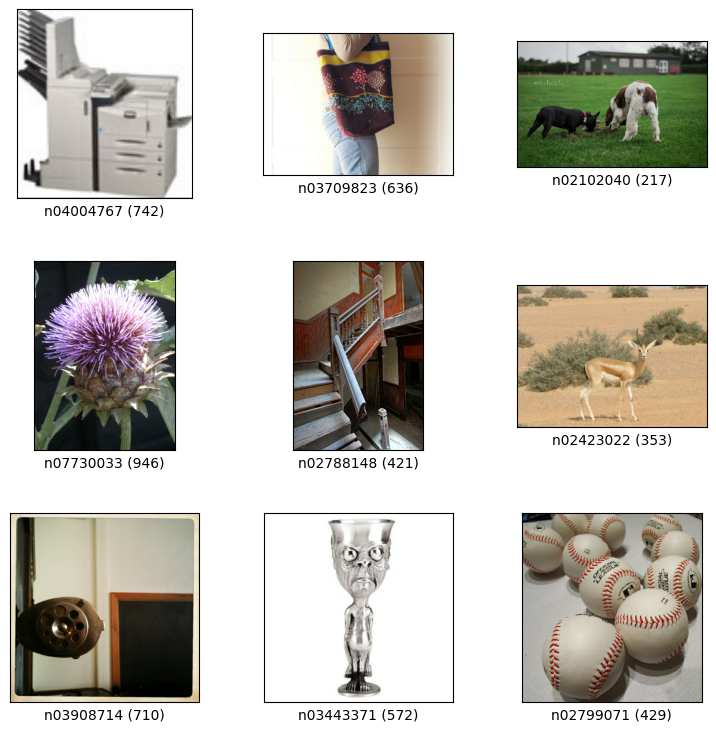

In [ ]:
# Download ImageNet-v2 dataset
DS, info = tfds.load(
    "imagenet_v2", split="test", with_info=True,
    # shuffle_files=True,
)

# Obtaining dataset information.
print(f"Number of classes: {info.features['label'].num_classes}")
# print(f"Classes: {info.features['label'].names}")
print(f"Number of images: {len(DS)}")

# Visualize dataset images. Can show only <= 9 images
_ = tfds.show_examples(DS.take(12), info)

In [ ]:
# Download imagenet-sample-images dataset
!git clone https://github.com/EliSchwartz/imagenet-sample-images

DS_IMAGES = get_images("imagenet-sample-images")
print(f"Number of images: {len(DS_IMAGES)}")

Cloning into 'imagenet-sample-images'...
remote: Enumerating objects: 1012, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1012 (delta 3), reused 5 (delta 2), pack-reused 1002
Receiving objects: 100% (1012/1012), 103.84 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Number of images: 1000


In [ ]:
def representative_dataset(model_path):
    """ Integer quantization requires a representative dataset, i.e. a few
        images from the training dataset, for the conversion to happen.
        This dataset can be a small subset (around ~100-500 samples)
        of the training or validation data. """
    images = []

    # # Use ImageNet-v2 dataset
    # for data in DS.take(150):  # take ~100-500 samples
    #     img = tf.image.resize(data["image"], IMAGE_SHAPE[0:2], method=RESIZE_METHOD2)

    # Use imagenet-sample-images
    for name, img in list(DS_IMAGES.items())[:100]:  # take ~100-500 samples
        img = tf.image.resize(img, IMAGE_SHAPE[0:2], method=RESIZE_METHOD2)

        img = tf.cast(img, tf.float32)  # convert from uint8 to float32
        # Normalize or not
        if "_v1_" in model_path or "_v2_" in model_path:  # normalize
            img = img / 127.5 - 1.0
        elif "_v3_" in model_path:  # don't normalize
            pass
        else:  # don't normalize
            print("Warning: not a MobileNet model")
            pass
        images.append(img)

    # Return (yield) slices (1,224,224,3) from "images" list
    slices = tf.data.Dataset.from_tensor_slices(images).batch(1)
    for s in slices:
        yield [s]


def tflite_convert(name, ext=".tflite", unpack=False, optim=None):
    """ Convert the model to TF Lite """
    # Untar *.tgz file with the model (not necessary in this notebook)
    if unpack:
        extract(name + ".tgz")
    # Convert the model to TFLite
    converter = tf.lite.TFLiteConverter.from_saved_model(name)

    if optim is None:  # no quantization
        print(separator(f"TF Lite convertion for {name}"))
    # Q1. Dynamic range quantization
    if optim == "dynamic":
        print(separator(f"Dynamic range quantization for {name}"))
        ext = "_dynamic" + ext
        converter.optimizations = [
            tf.lite.Optimize.DEFAULT,  # set the optimization mode
            # size reduction optimization doesn't work for standard model
            tf.lite.Optimize.EXPERIMENTAL_SPARSITY,  # size reduction
        ]
    # Q2. Float16 quantization
    elif optim == "float16":
        print(separator(f"Float16 quantization for {name}"))
        ext = "_float16" + ext
        converter.optimizations = [tf.lite.Optimize.DEFAULT]  # set the optimization mode
        converter.target_spec.supported_types = [tf.float16]  # float16 quantization
    # Q3. Full integer quantization
    elif optim == "int8":
        print(separator(f"Full integer quantization for {name}"))
        ext = "_int8" + ext
        converter.optimizations = [tf.lite.Optimize.DEFAULT]  # set the optimization mode
        converter.representative_dataset = lambda: representative_dataset(name)
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8  # or tf.int8
        converter.inference_output_type = tf.uint8  # or tf.int8
    elif optim is not None:
        print(f"Warning: no such optimization `{optim}`.")

    model_tflite = converter.convert()
    del converter
    # Save the TFLite model
    tf.io.write_file(name + ext, model_tflite)

## Run speed benchmarks for TFLite models

**Note**: This table is not informative. View tables from chapter [Estimate accuracy and speed on ImageNet-v2 dataset](#scrollTo=Pos-k0cVcpWf) with average data on 10000 images.

Table columns:

   * **TF**: TF model
   * **Converted**: converted to TFLite without optimizations
   * **Dynamic**: dynamic range quantization
   * **Float16**: quantized from `float32` to `float16`
   * **Int8**: full integer quantization

Benchmarks for `parrot.jpg` image in milliseconds (ms).

* Table1. **Google CoLab** on CPU *Intel Xeon 2.30 GHz* and *T4* GPU. TPU model is unknown. Benchmark time can be **very** different for different runs. Possible because the equipment is used by many users at the same time. For this reason, do 5-7 runs and choose the minimum execution time.

<br>

| Model        | TF                    | Converted          | Dynamic            | Float16            | Int8               |
| ------------ | --------------------- | ------------------ | ------------------ | ------------------ | ------------------ |
|              | CPU   / GPU   / TPU   | CPU  / GPU  / TPU  | CPU  / GPU  / TPU  | CPU  / GPU  / TPU  | CPU  / GPU  / TPU  |
| v1           | 149.6 /  50.6 / 141.9 | 50.5 / 41.3 / 53.5 | 56.3 / 30.9 / 54.0 | 50.5 / 42.1 / 51.9 | 59.0 / 31.4 / 58.0 |
| v2           | 194.9 /  88.8 / 200.0 | 13.8 / 10.6 / 21.0 | 39.0 / 24.9 / 40.6 | 14.1 / 10.6 / 21.5 | 20.4 / 12.4 / 20.5 |
| v3_large     | 262.0 / 156.2 / 246.6 | 12.5 /  9.4 / 18.0 | 31.0 / 21.0 / 33.0 | 12.9 /  9.6 / 19.0 | 46.5 / 38.7 / 63.9 |
| v3_large_min | 164.8 /  79.2 / 171.6 | 10.4 /  8.2 / 16.0 | 26.2 / 16.6 / 28.4 | 10.3 /  7.9 / 15.9 | 15.0 /  9.7 / 14.8 |
| v3_small     | 183.5 / 143.0 / 253.0 |  4.2 /  3.0 /  6.1 |  9.8 /  6.8 / 11.2 |  4.3 /  3.2 /  6.3 | 11.5 / 10.3 / 20.3 |
| v3_small_min |  87.6 /  61.0 / 101.6 |  3.1 /  2.3 /  4.7 |  7.4 /  5.1 /  8.6 |  3.1 /  2.4 /  4.8 |  5.4 /  4.2 /  5.6 |

<br>

* Table2. Single board computer **Cool Pi 4 Model B**. Chipset: Rockchip RK3588s. CPU: Cortex-A76 (2400 MHz, 4 cores) and Cortex-A55 (1800 MHz, 4 cores).

The indicator did not blink. So the application didn't actually run on Google Coral Accelerator.

| Model        | TF    | Converted | Dynamic   | Float16   | Int8        |
| ------------ | ----- | --------- | --------- | --------- | ----------- |
|              |       |           |           |           | CPU / TPU   |
| v1           | 151.1 | 43.6      | 23.4      | 43.5      | 19.6 / 18.7 |
| v2           | 190.8 | 22.6      | 21.3      | 22.5      | 11.6 / 19.6 |
| v3_large     | 257.2 | 18.2      | 18.4      | 18.4      | 20.3 / 19.2 |
| v3_large_min | 160.0 | 15.7      | 14.0      | 15.6      |  8.6 / 13.8 |
| v3_small     | 177.9 |  5.8      |  7.0      |  5.8      |  8.5 /  8.0 |
| v3_small_min |  92.9 |  4.6      |  4.8      |  4.5      |  3.0 /  5.2 |

<br>

* Table3. Single board computer **Raspberry Pi4**. Chipset: Broadcom BCM2711. CPU: Cortex-A72 (1800 MHz, 4 cores).

**The indicator did not blink**. So the application didn't actually run on Google Coral Accelerator.

| Model        | TF    | Converted | Dynamic | Float16 | Int8         |
| ------------ | ----- | --------- | ------- | ------- | ------------ |
|              |       |           |         |         | CPU  / TPU   |
| v1           | 366.9 | 149.3     | 112.1   | 149.5   | 89.7 / 90.93 |
| v2           | 531.5 |  80.3     |  85.6   |  80.6   | 49.6 / 75.70 |
| v3_large     | 802.5 |  67.5     |  74.2   |  68.6   | 69.0 / 65.14 |
| v3_large_min | 463.6 |  56.3     |  60.3   |  56.8   | 35.4 / 52.50 |
| v3_small     | 631.5 |  20.5     |  23.9   |  20.6   | 14.5 / 23.92 |
| v3_small_min | 306.6 |  15.2     |  17.4   |  15.7   | 11.7 / 17.32 |


**Results**

   * Functions `preprocess_input` and `decode_predictions` are convenient, but for TF Lite we have to implement them by hand.

   * TF Lite models from 3x to 30x+ faster than TF models whithout any optimization.

   * Runtime speed for converted TF Lite v1 is slow (57 ms) if compare with v2 (17 ms) and v3 (15 ms).

   * Runtime for lightweight converted versions of v3 is faster: 15 ms versus 12 ms, 5 ms and 4 ms.

   * GPU runtime is 2x+ faster for unconverted TF models.

   * CPU, GPU, TPU runtimes do not differ significantly for the converted TF Lite model.

   * Run on TPU is **slower** for unoptimized models (both converted and unconverted).

   * No visible improvements for `tf.lite.Optimize.EXPERIMENTAL_SPARSITY` option. At least for default MobileNet models.

   * Dynamic range quantization makes model 3.7x smaller, but **2x slower** for v2 and v3. For v1 runtime is the same. For CPU, GPU and TPU.

   * Float16 quantization makes model 2x smaller, but runtime **speed is the same** as for float32. For CPU, GPU and TPU.

   *  Full integer quantization makes model 3.5x smaller, but **slower**.

   

In [ ]:
def run_converted(img_path, model_path, ext=".tflite"):
    """ Run converted TF Lite model for image """
    model_path += ext  # use "*.tflite" files
    print(model_path)

    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    height = input_details["shape"][1]  # NxHxWxC or [1, 224, 224, 3], H:1, W:2
    width = input_details["shape"][2]
    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    norm, mean = 127.5, 127.5
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # Image data must go through two transforms before running inference:
    #     1. normalization: f = (input - mean) / norm
    #     2. quantization: q = f / scale + zero_point
    # The following code combines the two steps as such:
    #     q = (input - mean) / (norm * scale) + zero_point
    #
    # However, if norm * scale equals 1, and mean - zero_point equals 0, the input
    #   does not need any preprocessing (but in practice, even if the results are
    #   very close to 1 and 0, it is probably okay to skip preprocessing for better
    #   efficiency; we use 1e-5 below instead of absolute zero).
    #
    # There are following options:
    #   | No. | Normalization | Quantization | Details          |
    #   | --- | ------------- | ------------ | ---------------- |
    #   | 1   | yes           | no           |                  |
    #   | 2   | no            | no           |                  |
    #   | 3   | no            | yes          |                  |
    #   | 4   | yes           | yes          | No preprocessing |
    #   | 5   | yes           | yes          |                  |
    img = Image.open(img_path).resize((width, height), RESIZE_METHOD)
    # 1. Normalization - yes. Quantization - no.
    if ("_v1_" in model_path or "_v2_" in model_path) and \
      (scale.size == 0 or zero_point.size == 0):
        print("- 1 -")
        img = (np.asarray(img) - mean) / norm
    # 2. Normalization - no. Quantization - no.
    elif ("_v3_" in model_path) and (scale.size == 0 or zero_point.size == 0):
        print("- 2 -")
        pass
    # 3. Normalization - no. Quantization - yes.
    elif "v3" in model_path:
        print("- 3 -")
        img = np.asarray(img) / scale + zero_point
    # 4. Norm - yes. Quant - yes. No preprocessing.
    elif abs(scale * norm - 1) < 1e-5 and abs(int(mean) - zero_point) < 1e-5:
        print("- 4 -")
        pass
    # 5. Normalization - yes. Quantization - yes.
    else:
        print("- 5 -")
        img = (np.asarray(img) - mean) / (norm * scale) + zero_point
        np.clip(img, 0, 255, out=img)  # clip values to [0, 255]. Not sure if this is necessary

    img = np.asarray(img, dtype=dtype)  # convert to necessary type
    img = np.expand_dims(img, axis=0)  # [224, 224, 3] to [1, 224, 224, 3]
    interpreter.set_tensor(input_details["index"], img)

    print(separator("INFERENCE TIME"))
    runtime = []
    for _ in range(COUNT):
        start_time = time.time()
        interpreter.invoke()  # predict using TF Lite
        stop_time = time.time()
        runtime.append((stop_time - start_time) * 1000)
        print(f"{(runtime[-1]):.1f} ms")

    print(separator("RESULTS"))
    # interpreter.get_tensor() copies data, but interpreter.tensor() avoids copying data
    results = interpreter.tensor(output_details["index"])().flatten()

    # De-quantize, if necessary
    if output_details["quantization"][0] and \
       np.issubdtype(output_details["dtype"], np.integer):
        print(" - de-quantize -")
        # Usually scale == 1/256 and zero_point == 0
        scale, zero_point = output_details["quantization"]
        # Always convert to np.int64 to avoid overflow on subtraction.
        results = scale * (results.astype(np.int64) - zero_point)

    # Clear resources to prevent error: "Segmentation fault (core dumped)"
    del interpreter

    print(decode_predictions(results))
    return average_runtime(runtime)

### TFLite convertion and benchmarks

In [ ]:
for k, v in mobilenet.items():
    tflite_convert(v[0], unpack=True)

------------ TF Lite convertion for mobilenet_v1_1.0_224  ------------
------------ TF Lite convertion for mobilenet_v2_1.0_224  ------------
--------- TF Lite convertion for mobilenet_v3_large_1.0_224  ---------
--- TF Lite convertion for mobilenet_v3_large_minimalistic_1.0_224 ---
--------- TF Lite convertion for mobilenet_v3_small_1.0_224  ---------
--- TF Lite convertion for mobilenet_v3_small_minimalistic_1.0_224 ---


In [ ]:
benchmark(BENCHMARK_IMG, run_converted)


------------------------ mobilenet_v1_1.0_224 ------------------------

mobilenet_v1_1.0_224.tflite
- 1 -
--------------------------- INFERENCE TIME ---------------------------
79.6 ms
54.8 ms
53.1 ms
49.1 ms
47.8 ms
48.2 ms
47.9 ms
50.6 ms
46.7 ms
63.3 ms
57.4 ms
52.0 ms
51.3 ms
49.7 ms
54.8 ms
52.7 ms
54.9 ms
48.8 ms
48.8 ms
49.0 ms
54.6 ms
49.2 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9998'), ('bee_eater', '0.0001'), ('lorikeet', '0.0001')]
Average time of the last 20 runs:   51.5 ms

------------------------ mobilenet_v2_1.0_224 ------------------------

mobilenet_v2_1.0_224.tflite
- 1 -
--------------------------- INFERENCE TIME ---------------------------
15.7 ms
13.4 ms
13.4 ms
13.3 ms
17.0 ms
13.4 ms
13.3 ms
14.4 ms
14.6 ms
13.7 ms
13.4 ms
13.5 ms
13.7 ms
13.4 ms
13.1 ms
13.3 ms
13.1 ms
14.7 ms
13.3 ms
19.1 ms
16.7 ms
14.0 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9413'), ('lorikeet', 

### Dynamic range quantization

In [ ]:
for k, v in mobilenet.items():
    tflite_convert(v[0], unpack=True, optim="dynamic")

-------- Dynamic range quantization for mobilenet_v1_1.0_224  --------
-------- Dynamic range quantization for mobilenet_v2_1.0_224  --------
----- Dynamic range quantization for mobilenet_v3_large_1.0_224  -----
Dynamic range quantization for mobilenet_v3_large_minimalistic_1.0_224
----- Dynamic range quantization for mobilenet_v3_small_1.0_224  -----
Dynamic range quantization for mobilenet_v3_small_minimalistic_1.0_224


In [ ]:
benchmark(BENCHMARK_IMG, lambda img_path, model_path: run_converted(img_path, model_path, ext="_dynamic.tflite"))


------------------------ mobilenet_v1_1.0_224 ------------------------

mobilenet_v1_1.0_224_dynamic.tflite
- 1 -
--------------------------- INFERENCE TIME ---------------------------
56.3 ms
55.3 ms
55.5 ms
59.0 ms
55.2 ms
53.7 ms
53.3 ms
56.8 ms
59.8 ms
53.6 ms
60.4 ms
60.1 ms
54.5 ms
55.8 ms
54.1 ms
58.7 ms
55.1 ms
53.3 ms
54.3 ms
58.4 ms
55.1 ms
58.9 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9998'), ('bee_eater', '0.0001'), ('lorikeet', '0.0000')]
Average time of the last 20 runs:   56.3 ms

------------------------ mobilenet_v2_1.0_224 ------------------------

mobilenet_v2_1.0_224_dynamic.tflite
- 1 -
--------------------------- INFERENCE TIME ---------------------------
46.2 ms
40.5 ms
35.5 ms
36.1 ms
39.5 ms
43.0 ms
36.1 ms
35.6 ms
37.6 ms
34.1 ms
34.7 ms
34.8 ms
33.7 ms
35.0 ms
33.3 ms
36.4 ms
34.5 ms
34.7 ms
34.5 ms
47.3 ms
46.1 ms
44.1 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9314'

### Float16 quantization

In [ ]:
for k, v in mobilenet.items():
    tflite_convert(v[0], unpack=True, optim="float16")

----------- Float16 quantization for mobilenet_v1_1.0_224  -----------
----------- Float16 quantization for mobilenet_v2_1.0_224  -----------
-------- Float16 quantization for mobilenet_v3_large_1.0_224  --------
-- Float16 quantization for mobilenet_v3_large_minimalistic_1.0_224 --
-------- Float16 quantization for mobilenet_v3_small_1.0_224  --------
-- Float16 quantization for mobilenet_v3_small_minimalistic_1.0_224 --


In [ ]:
benchmark(BENCHMARK_IMG, lambda img_path, model_path: run_converted(img_path, model_path, ext="_float16.tflite"))


------------------------ mobilenet_v1_1.0_224 ------------------------

mobilenet_v1_1.0_224_float16.tflite
- 1 -
--------------------------- INFERENCE TIME ---------------------------
117.7 ms
51.2 ms
56.8 ms
61.9 ms
64.3 ms
54.3 ms
79.5 ms
53.7 ms
62.9 ms
56.3 ms
52.6 ms
50.6 ms
45.9 ms
45.4 ms
47.3 ms
48.0 ms
43.2 ms
44.7 ms
42.7 ms
43.8 ms
46.4 ms
43.1 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9998'), ('bee_eater', '0.0002'), ('lorikeet', '0.0001')]
Average time of the last 20 runs:   52.2 ms

------------------------ mobilenet_v2_1.0_224 ------------------------

mobilenet_v2_1.0_224_float16.tflite
- 1 -
--------------------------- INFERENCE TIME ---------------------------
13.5 ms
12.3 ms
12.4 ms
14.5 ms
12.0 ms
13.2 ms
11.9 ms
11.9 ms
14.5 ms
12.4 ms
12.5 ms
11.9 ms
12.1 ms
12.1 ms
15.3 ms
12.3 ms
15.7 ms
17.0 ms
12.1 ms
17.9 ms
11.9 ms
11.9 ms
------------------------------ RESULTS  ------------------------------
[('macaw', '0.9426

### Full integer quantization

* MobileNet v1 and v2 are OK for int8 quantization. However **v3 has poor evaluation for int8 quantization**.

* It is better to use train or validation images than test images from ImageNet-v2.

In [ ]:
for k, v in mobilenet.items():
    tflite_convert(v[0], unpack=True, optim="int8")

--------- Full integer quantization for mobilenet_v1_1.0_224 ---------
--------- Full integer quantization for mobilenet_v2_1.0_224 ---------
------ Full integer quantization for mobilenet_v3_large_1.0_224 ------
Full integer quantization for mobilenet_v3_large_minimalistic_1.0_224
------ Full integer quantization for mobilenet_v3_small_1.0_224 ------
Full integer quantization for mobilenet_v3_small_minimalistic_1.0_224


In [ ]:
benchmark(BENCHMARK_IMG, lambda img_path, model_path: run_converted(img_path, model_path, ext="_int8.tflite"))


------------------------ mobilenet_v1_1.0_224 ------------------------

mobilenet_v1_1.0_224_int8.tflite
- 4 -
--------------------------- INFERENCE TIME ---------------------------
64.8 ms
58.0 ms
61.9 ms
58.4 ms
59.5 ms
59.0 ms
68.4 ms
60.0 ms
64.4 ms
59.5 ms
59.0 ms
58.6 ms
59.5 ms
64.3 ms
59.5 ms
57.8 ms
57.9 ms
59.0 ms
63.9 ms
58.2 ms
57.5 ms
58.7 ms
------------------------------ RESULTS  ------------------------------
 - de-quantize -
[('macaw', '0.9961'), ('toilet_tissue', '0.0000'), ('sea_cucumber', '0.0000')]
Average time of the last 20 runs:   60.3 ms

------------------------ mobilenet_v2_1.0_224 ------------------------

mobilenet_v2_1.0_224_int8.tflite
- 4 -
--------------------------- INFERENCE TIME ---------------------------
21.0 ms
27.1 ms
18.0 ms
17.7 ms
17.6 ms
19.9 ms
17.8 ms
19.9 ms
18.2 ms
17.8 ms
21.5 ms
17.8 ms
21.2 ms
17.7 ms
17.9 ms
18.2 ms
18.5 ms
18.4 ms
17.5 ms
17.8 ms
17.8 ms
24.2 ms
------------------------------ RESULTS  ------------------------------


## Estimate file sizes

Table4. Model size in megabytes (M).
Divide bytes on 1024 to get kilobytes and megabytes.

   * **TF**: directory size of the TF model
   * **Archived**: archived directory with the TF model, `*.tgz` files
   * **Converted**: converted to TFLite without optimizations, `*.tflite` files
   * **Dynamic**: dynamic range quantization, `*_dynamic.tflite` files
   * **Float16**: quantized from `float32` to `float16`, `*_float16.tflite` files
   * **Int8**: full integer quantization, `*_int8.tflite` files

<br>

| Model        | TF   | Archived | Converted | Dynamic | Float16 | Int8 |
| ------------ | ---- | ---------| --------- | ------- | ------- | ---- |
| v1           | 17.8 | 15.2     | 16.1      | 4.2     |  8.1    | 4.4  |
| v2           | 16.4 | 12.8     | 13.3      | 3.6     |  6.7    | 3.8  |
| v3_large     | 24.6 | 19.8     | 20.9      | 5.6     | 10.5    | 5.8  |
| v3_large_min | 17.8 | 14.2     | 15.0      | 4.0     |  7.5    | 4.1  |
| v3_small     | 12.7 |  9.3     |  9.7      | 2.6     |  4.9    | 2.8  |
| v3_small_min |  9.9 |  7.5     |  7.8      | 2.1     |  3.9    | 2.2  |


**Results**

   * Unoptimized TF Lite models on several megabytes smaller than directory with TF model. From 10% to 20% smaller.

   * Dynamic range quantized models are 3.7-3.8 times smaller than unoptimized TF Lite.

   * Indeed, if change model weights from float32 to float16, its size will become approximately 2 times smaller.

   * Int8 is slightly bigger than Dynamic.

   * **Raspberry Pi4 cannot convert TFLite**. Some errors.

In [ ]:
!ls -als  # get info about all files (in bytes)

for k, v in mobilenet.items():
    !du -sb {v[0]}  # get size of the directory

total 255536
    4 drwxr-xr-x 9 root root     4096 Nov  2 13:24 .
    4 drwxr-xr-x 1 root root     4096 Nov  2 12:36 ..
  104 -rw-r--r-- 1 root root   104837 Nov  2 13:12 cat.jpg
  100 -rw-r--r-- 1 root root   101795 Nov  2 13:12 human.jpg
   36 -rw-r--r-- 1 root root    35363 Nov  2 12:41 imagenet_class_index.json
   56 drwxr-xr-x 3 root root    57344 Nov  2 13:18 imagenet-sample-images
    4 drwxr-xr-x 4 root root     4096 Nov  2 13:13 mobilenet_v1_1.0_224
 4324 -rw-r--r-- 1 root root  4425752 Nov  2 13:19 mobilenet_v1_1.0_224_dynamic.tflite
 8272 -rw-r--r-- 1 root root  8470292 Nov  2 13:21 mobilenet_v1_1.0_224_float16.tflite
 4460 -rw-r--r-- 1 root root  4565720 Nov  2 13:22 mobilenet_v1_1.0_224_int8.tflite
16508 -rw-r--r-- 1 root root 16903380 Nov  2 13:18 mobilenet_v1_1.0_224.tflite
15588 -rw-r--r-- 1 root root 15959355 Nov  2 13:13 mobilenet_v1_1.0_224.tgz
    4 drwxr-xr-x 4 root root     4096 Nov  2 13:13 mobilenet_v2_1.0_224
 3700 -rw-r--r-- 1 root root  3788768 Nov  2 13:20 m

## Estimate accuracy and speed on ImageNet-v2 dataset

Columns are the same as for benchmarks.

<br>

Table5. Accuracy in % for **Google Colab**.

| Model Acc, % | TF   | Converted | Dynamic         | Float16 | Int8 |
| ------------ | ---- | --------- | --------------- | ------- | ---- |
|              |      |           | CPU / GPU / TPU |         | CPU / GPU / TPU |
| v1           | 56.3 | 56.3      | 56.0 / / 55.9   | 56.2    | 55.0 |
| v2           | 57.2 | 57.2      | 56.9 / / 56.8   | 57.2    | 56.4 |
| v3_large     | 59.2 | 59.2      | 58.7 / / 58.6   | 59.2    | 15.3 / 17.9 / 21.3 |
| v3_large_min | 55.9 | 55.9      | 55.7            | 55.9    | 52.1 / 51.8 / 51.8 |
| v3_small     | 50.6 | 50.6      | 49.1            | 50.6    | 26.3 / 22.8 / 28.9 |
| v3_small_min | 45.2 | 45.2      | 44.6 / / 44.4   | 45.3    | 29.8 / 28.8 / 30.2 |

<br>

Table6. Accuracy in % for **Cool Pi 4 Model B**.

| Model Acc, % | TF   | Converted | Dynamic | Float16 | Int8 |
| ------------ | ---- | --------- | ------- | ------- | ---- |
| v1           | 56.3 | 56.3      | 55.9    | 56.2    | 55.0 |
| v2           | 57.2 | 57.2      | 56.9    | 57.2    | 56.6 |
| v3_large     | 59.2 | 59.2      | 58.7    | 59.2    | 12.9 |
| v3_large_min | 55.9 | 55.9      | 55.6    | 55.9    | 52.1 |
| v3_small     | 50.6 | 50.6      | 49.2    | 50.6    | 25.0 |
| v3_small_min | 45.2 | 45.2      | 44.5    | 45.3    | 28.1 |

<br>

Table7. Accuracy in % for **Raspberry Pi4**.

| Model Acc, % | TF   | Converted | Dynamic | Float16 | Int8 |
| ------------ | ---- | --------- | ------- | ------- | ---- |
| v1           | 56.3 | 56.3      | 55.9    | 56.2    | 55.0 |
| v2           | 57.2 | 57.2      | 57.0    | 57.2    | 56.6 |
| v3_large     | 59.2 | 59.2      | 58.8    | 59.2    | 12.9 |
| v3_large_min | 55.9 | 55.9      | 55.7    | 55.9    | 52.1 |
| v3_small     | 50.6 | 50.6      | 49.2    | 50.6    | 25.0 |
| v3_small_min | 45.2 | 45.2      | 44.6    | 45.3    | 28.1 |

<br>

Table8. Runtime in seconds on **Google CoLab** CPU and GPU.

| Model Run, s | TF  | Converted | Dynamic | Float16 | Int8 |
| ------------ | --- | --------- | ------- | ------- | ---- |
|              | CPU / GPU / TPU | CPU / GPU / TPU | CPU / GPU / TPU | CPU / GPU / TPU | CPU / GPU / TPU |
| v1           | 1462.1 /  537.8 / 1749.3 | 667.3 / 479.3 / 658.6 | 683.5 / 344.9 / 666.7 | 682.1 / 481.5 / 682.2 | 696.6 / 442.1 / 742.2 |
| v2           | 1942.1 /  865.7 / 2362.4 | 262.0 / 145.5 / 322.2 | 502.1 / 284.6 / 510.6 | 202.1 / 202.0 / 322.1 | 322.1 / 202.0 / 322.1 |
| v3_large     | 2902.2 / 1522.0 / 2963.2 | 202.1 / 142.0 / 259.6 | 366.2 / 262.1 / 442.2 | 191.3 / 138.4 / 262.2 | 577.7 / 442.0 / 862.2 |
| v3_large_min | 1642.1 /  829.3 / 2062.9 | 202.1 / 142.0 / 225.1 | 382.1 / 202.0 / 382.1 | 164.0 / 115.2 / 262.2 | 224.0 / 142.0 / 262.1 |
| v3_small     | 2215.5 / 1402.0 / 2138.9 |  89.4 /  63.6 / 142.1 | 142.0 / 101.5 / 202.3 | 142.0 /  82.0 / 142.2 | 179.3 / 142.0 / 306.8 |
| v3_small_min | 1042.1 /  614.1 / 1247.0 |  75.6 /  82.0 /  97.1 | 118.8 /  82.0 / 139.8 |  82.1 /  54.8 / 142.2 | 116.2 /  73.5 / 133.7 |

<br>

Table9. Runtime in seconds on **Cool Pi 4 Model B**.

| Model Run, s | TF     | Converted | Dynamic | Float16 | Int8  |
| ------------ | ------ | --------- | ------- | ------- | ----- |
| v1           | 1433.8 | 451.7     | 243.9   | 448.2   | 230.7 |
| v2           | 1840.5 | 248.9     | 234.1   | 251.6   | 146.7 |
| v3_large     | 2333.2 | 195.0     | 198.2   | 196.5   | 232.1 |
| v3_large_min | 1524.7 | 169.2     | 152.4   | 166.9   | 116.9 |
| v3_small     | 1641.8 |  72.4     |  83.6   |  72.9   |  75.4 |
| v3_small_min |  894.4 |  68.0     |  68.3   |  67.4   |  68.7 |

<br>

Table10. Runtime in seconds on Raspberry Pi4.

| Model Run, s | TF     | Converted | Dynamic | Float16 | Int8  |
| ------------ | ------ | --------- | ------- | ------- | ----- |
| v1           | 3671.2 | 1522.4    | 1102.3  | 1449.7  | 983.8 |
| v2           | 5343.3 |  817.0    |  922.2  |  815.5  | 618.2 |
| v3_large     | 7652.6 |  662.1    |  755.0  |  661.2  | 772.7 |
| v3_large_min | 4664.6 |  562.0    |  620.7  |  564.4  | 435.5 |
| v3_small     | 5962.4 |  262.3    |  280.3  |  245.6  | 262.3 |
| v3_small_min | 3049.2 |  192.3    |  216.2  |  191.8  | 262.2 |


**Results**

   * It is possible not to make normalization-quantization for fully quantized models for all versions v1, v2, v3, files `*_int8.tflite`.

   * `model.evaluate` function is much faster than implementation by hand. Use a manual implementation to test execution speed.

   * Optimizing TFLite for Xeon processors did not lead to significant improvement.

   * For Cool Pi4 and Raspberry Pi4 need at least **5 GB RAM**, but had only 3.6 GB and 3.7 GB. Thus Jupyter kernel restarded frequently. I did tests in parts.


In [ ]:
def prepare(datapoint, model_path):
    """ Prepare data and return (image, label) tuple """
    img = tf.image.resize(datapoint["image"], IMAGE_SHAPE[0:2], method=RESIZE_METHOD2)
    img = tf.cast(img, tf.float32)  # convert from uint8 to float32
    # Normalize or not
    if "_v1_" in model_path or "_v2_" in model_path:  # normalize
        img = img / 127.5 - 1.0
    elif "_v3_" in model_path:  # don't normalize
        pass
    else:  # don't normalize
        print("Warning: not a MobileNet model")
        pass
    return img, datapoint["label"]


def prepare_simple(datapoint, model_path):
    """ Prepare data and return (image, label) tuple """
    img = tf.image.resize(datapoint["image"], IMAGE_SHAPE[0:2], method=RESIZE_METHOD2)
    img = tf.cast(img, tf.float32)  # convert from uint8 to float32
    return img, datapoint["label"]


def evaluate_simple(data, model_path, ext=".tflite"):
    """ TFLite model evaluation function """
    model_path += ext  # use "*.tflite" files
    print(f"{ext} - simple")

    interpreter = tf.lite.Interpreter(model_path)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_output_details()[0]['dtype']

    true_labels = []
    predictions = []
    total = len(data)
    start_time = time.time()
    for i, (img, label) in enumerate(data):
        if i % 100 == 0:
            print(f"\r" f"Evaluated {i} from {total}", end="")

        img = tf.cast(img, dtype=input_format)  # convert to necessary type
        img = tf.expand_dims(img, axis=0)  # [224,224,3] to [1,224,224,3]
        interpreter.set_tensor(input_index, img)
        interpreter.invoke()  # run inference
        results = interpreter.tensor(output_index)
        i = np.argmax(results()[0])
        predictions.append(i)
        true_labels.append(label)

    print("\r", end="")
    del interpreter
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} s" f"\n")


def evaluate(data, model_path, ext=".tflite"):
    """ TFLite model evaluation function """
    model_path += ext  # use "*.tflite" files
    print(ext)

    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()  # allocate memory for the model's input tensors

    # Use input and output details to get info about model parameters
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # # Visualize in/out details. Uncomment for debug purposes
    # print(f"\n" f"input_details:")
    # for k, v in input_details.items():
    #     print(f"{k} => {v}")
    # print(f"\n" f"output_details:")
    # for k, v in output_details.items():
    #     print(f"{k} => {v}")
    # print()

    params = input_details["quantization_parameters"]
    scale, zero_point = params["scales"], params["zero_points"]
    dtype = input_details["dtype"]  # float32 or int for quantized model

    # De-quantization is not necessary, because took max value without accuracy
    quant = False  # quantization
    if scale.size == 0 or zero_point.size == 0:
        pass
    else:
        # print("quantization - yes")
        quant = True

    true_labels = []
    predictions = []
    total = len(data)
    start_time = time.time()
    for i, (img, label) in enumerate(data):
        if i % 100 == 0:
            print(f"\r" f"Evaluated {i} from {total}", end="")

        # Image data can go through quantization before running inference:
        #     quantization: q = f / scale + zero_point
        if quant:
            img = img / scale + zero_point
            img = tf.clip_by_value(img, 0, 255)  # not sure if this is necessary

        img = tf.cast(img, dtype=dtype)  # convert to necessary type
        img = tf.expand_dims(img, axis=0)  # [224,224,3] to [1,224,224,3]
        interpreter.set_tensor(input_details["index"], img)
        interpreter.invoke()  # predict using TF Lite
        results = interpreter.tensor(output_details["index"])().flatten()
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    print("\r", end="")
    del interpreter
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} s" f"\n")


def evaluate_tf_simple(data, model_path):
    """ TF model evaluation function """
    print(model_path)
    model = load_model(model_path)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    start_time = time.time()
    _, accuracy = model.evaluate(data.batch(1))
    runtime = time.time() - start_time  # runtime in seconds
    del model
    print(f"Accuracy: {(accuracy*100):.1f} %; time: {runtime:.1f} s" f"\n")


def evaluate_tf(data, model_path):
    """ TF model evaluation function.
        Evaluate every image by hand. """
    print(model_path)
    model = load_model(model_path)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    true_labels = []
    predictions = []
    total = len(data)

    start_time = time.time()
    for i, (img, label) in enumerate(data):
        if i % 100 == 0:
            print(f"\r" f"Evaluated {i} from {total}", end="")
        img = tf.expand_dims(img, axis=0)  # [224,224,3] to [1,224,224,3]
        results = model(img, training=False)  # predict
        results = results.numpy()[0]  # convert from tf to numpy
        i = np.argmax(results)
        predictions.append(i)
        true_labels.append(label)

    print("\r", end="")
    del model
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = (predictions == true_labels).mean() * 100  # get accuracy in %
    runtime = time.time() - start_time  # runtime in seconds
    print(f"Accuracy: {accuracy:.1f} %; time: {runtime:.1f} s" f"\n")

In [ ]:
# Let's make preliminary tests
# It is possible not to make normalization-quantization
#   for fully quantized models, all versions v1, v2, v3

N = 50  # len(DS)
for k, v in mobilenet.items():
    data = DS.take(N).map(lambda x: prepare(x, v[0]))
    data2 = DS.take(N).map(lambda x: prepare_simple(x, v[0]))

    print(separator(v[0]))
    evaluate_tf(data, v[0])
    for e in [".tflite", "_dynamic.tflite", "_float16.tflite", "_int8.tflite"]:
        evaluate_simple(data2, v[0], ext=e)
        evaluate(data, v[0], ext=e)

------------------------ mobilenet_v1_1.0_224 ------------------------
mobilenet_v1_1.0_224
Accuracy: 48.0 %; time: 7.4 s

.tflite - simple
Accuracy: 0.0 %; time: 3.3 s

.tflite
Accuracy: 48.0 %; time: 3.0 s

_dynamic.tflite - simple
Accuracy: 0.0 %; time: 5.2 s

_dynamic.tflite
Accuracy: 52.0 %; time: 3.8 s

_float16.tflite - simple
Accuracy: 0.0 %; time: 5.2 s

_float16.tflite
Accuracy: 48.0 %; time: 2.7 s

_int8.tflite - simple
Accuracy: 46.0 %; time: 5.1 s

_int8.tflite
Accuracy: 44.0 %; time: 5.1 s

------------------------ mobilenet_v2_1.0_224 ------------------------
mobilenet_v2_1.0_224
Accuracy: 50.0 %; time: 10.3 s

.tflite - simple
Accuracy: 0.0 %; time: 1.3 s

.tflite
Accuracy: 50.0 %; time: 1.0 s

_dynamic.tflite - simple
Accuracy: 0.0 %; time: 2.1 s

_dynamic.tflite
Accuracy: 48.0 %; time: 2.6 s

_float16.tflite - simple
Accuracy: 0.0 %; time: 1.3 s

_float16.tflite
Accuracy: 50.0 %; time: 2.6 s

_int8.tflite - simple
Accuracy: 48.0 %; time: 1.2 s

_int8.tflite
Accuracy: 

In [ ]:
%%script echo "Skip this cell. Runtime ≈ 5 hours for CPU and 3 hours for GPU."

# Final evaluations
N = len(DS)  # 100
for k, v in mobilenet.items():
    print(separator(v[0]))
    data = DS.take(N).map(lambda x: prepare(x, v[0]))
    evaluate_tf(data, v[0])
    for e in [".tflite", "_dynamic.tflite", "_float16.tflite", "_int8.tflite",]:
        evaluate(data, v[0], ext=e)

Skip this cell. Runtime ≈ 5 hours for CPU and 3 hours for GPU.


## Optional tests

Optional tests to check resize parameters on various datasets.

There are several datasets labelled with ImageNet labels used to test the robustness of vision models (in `tfds` repository):
   * [ImageNet-A](https://www.tensorflow.org/datasets/catalog/imagenet_a) is a set of images labelled with ImageNet labels that were obtained by collecting new data and keeping only those images that **ResNet-50 models fail to correctly classify**.
   * [ImageNet-v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2) is a **new** ImageNet test set (10 per class) collected by closely following the original labelling protocol.
   * [ImageNet-Sketch](https://www.tensorflow.org/datasets/catalog/imagenet_sketch) consists of 50,889 **black and white sketch images**, 50 for each of the 1000 ImageNet classes.
   * [ImageNet-R](https://www.tensorflow.org/datasets/catalog/imagenet_r) is a set of images labelled with ImageNet labels that were obtained by collecting various **art objects**.

Not in the `tfds` repository yet:
   * [ImageNet-O](https://paperswithcode.com/dataset/imagenet-o) consists of images from classes that are **not found in the ImageNet-1k dataset**.
   * [ImageNet-C](https://paperswithcode.com/dataset/imagenet-c) is an open source data set that consists of **algorithmically generated corruptions** (blur, noise) applied to the ImageNet test-set.
   * [ImageNet-P](https://paperswithcode.com/dataset/imagenet-p) consists of noise, blur, weather, and digital distortions. ImageNet-P **departs from ImageNet-C** by having perturbation sequences generated from each ImageNet validation image.

Tried the following datasets from `tfds`:
  [ImageNet-A](https://www.tensorflow.org/datasets/catalog/imagenet_a),
  [ImageNet-v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2),
  [ImageNet-Sketch](https://www.tensorflow.org/datasets/catalog/imagenet_sketch),
  [ImageNet-R](https://www.tensorflow.org/datasets/catalog/imagenet_r).

Tried different resize methods from [tf.image.ResizeMethod](https://www.tensorflow.org/api_docs/python/tf/image/ResizeMethod): area, bicubic, bilinear (default for TF), gaussian, lanczos3, lanczos5, mitchellcubic, nearest (default for PIL).
These methods differ in speed performance and quality of output resized image.

![Filters comparison table](https://i.stack.imgur.com/bKlzT.png)

**ImageNet-A**: has a very low accuracy, as it should be. Because these images are chosen to be difficult for ResNet neural networks to predict.

| Model        | bilinear, % | Loss  | \| | area  | bicubic | gaussian | lanczos3 | lanczos5 | mitchellcubic | nearest | bilinear,<br>antialias | bilinear,<br>aspect ratio |
| ------------ | ----------- | ----- | -- | ----- | ------- | -------- | -------- | -------- | ------------- | ------- | ---------------------- | ------------------------- |
| v1           | 1.560       | 8.751 | \| | 1.507 | 1.600   | 1.520    | 1.533    | 1.533    | 1.533         | 1.520   | 1.427                  | 1.440                     |
| v2           | 1.853       | 7.055 | \| | 1.760 | 1.853   | 1.880    | 1.853    | 1.827    | 1.840         | 1.800   | 1.613                  | 1.747                     |
| v3_large     | 2.653       | 6.892 | \| | 2.347 | 2.640   | 2.413    | 2.613    | 2.573    | 2.640         | 2.533   | 2.360                  | 2.053                     |
| v3_large_min | 1.613       | 7.100 | \| | 1.440 | 1.627   | 1.587    | 1.600    | 1.520    | 1.613         | 1.453   | 1.427                  | 1.293                     |
| v3_small     | 1.400       | 7.237 | \| | 1.387 | 1.333   | 1.440    | 1.307    | 1.293    | 1.347         | 1.360   | 1.307                  | 1.093                     |
| v3_small_min | 0.827       | 7.411 | \| | 0.773 | 0.867   | 0.813    | 0.853    | 0.773    | 0.827         | 0.853   | 0.760                  | 0.747                     |

    75/75 [==============================] - 20s 247ms/step - loss: 8.7509 - accuracy: 0.0156
    75/75 [==============================] - 21s 255ms/step - loss: 7.0553 - accuracy: 0.0185
    75/75 [==============================] - 21s 258ms/step - loss: 6.8919 - accuracy: 0.0265
    75/75 [==============================] - 21s 265ms/step - loss: 7.0997 - accuracy: 0.0161
    75/75 [==============================] - 20s 244ms/step - loss: 7.2368 - accuracy: 0.0140
    75/75 [==============================] - 19s 243ms/step - loss: 7.4111 - accuracy: 0.0083

**ImageNet-v2**: has much better results than **ImageNet-A**.

| Model        | bilinear, % | Loss  | \| | area   | bicubic | gaussian | lanczos3 | lanczos5 | mitchellcubic | nearest | bilinear,<br>antialias | bilinear,<br>aspect ratio |
| ------------ | ----------- | ----- | -- | ------ | ------- | -------- | -------- | -------- | ------------- | ------- | ---------------------- | ------------------------- |
| v1           | 56.270      | 2.102 | \| | 56.420 | 55.990  | 56.610   | 55.740   | 55.310   | 56.240        | 55.050  | 56.260                 | 50.270                    |
| v2           | 57.160      | 2.014 | \| | 57.060 | 56.770  | 57.430   | 56.360   | 55.920   | 57.290        | 54.790  | 55.670                 | 51.640                    |
| v3_large     | 59.190      | 1.836 | \| | 59.350 | 59.050  | 59.520   | 58.910   | 58.600   | 59.160        | 57.770  | 58.450                 | 54.230                    |
| v3_large_min | 55.930      | 2.032 | \| | 55.610 | 55.840  | 55.930   | 55.370   | 55.110   | 56.080        | 53.710  | 54.320                 | 50.050                    |
| v3_small     | 50.580      | 2.309 | \| | 50.710 | 50.480  | 50.800   | 50.450   | 50.230   | 50.780        | 49.180  | 49.580                 | 43.440                    |
| v3_small_min | 45.190      | 2.598 | \| | 44.770 | 45.030  | 45.220   | 44.890   | 44.380   | 45.390        | 43.370  | 43.410                 | 37.600                    |

    100/100 [==============================] - 36s 348ms/step - loss: 2.1022 - accuracy: 0.5627
    100/100 [==============================] - 34s 323ms/step - loss: 2.0138 - accuracy: 0.5716
    100/100 [==============================] - 33s 310ms/step - loss: 1.8362 - accuracy: 0.5919
    100/100 [==============================] - 32s 306ms/step - loss: 2.0316 - accuracy: 0.5593
    100/100 [==============================] - 33s 310ms/step - loss: 2.3087 - accuracy: 0.5058
    100/100 [==============================] - 31s 297ms/step - loss: 2.5979 - accuracy: 0.4519

**ImageNet-Sketch**: sketches are evaluated 2.6x+ worse than real images from **ImageNet-v2**.

| Model        | bilinear, % | Loss  | \| | area   | bicubic | gaussian | lanczos3 | lanczos5 | mitchellcubic | nearest | bilinear,<br>antialias | bilinear,<br>aspect ratio |
| ------------ | ----------- | ----- | -- | ------ | ------- | -------- | ---------| -------- | ------------- | ------- | ---------------------- | ------------------------- |
| v1           | 21.574      | 5.415 | \| | 22.875 | 21.128  | 21.914   | 20.898   | 20.824   | 21.496        | 20.574  | 23.027                 | 19.859                    |
| v2           | 19.993      | 5.024 | \| | 21.537 | 19.179  | 20.384   | 18.645   | 18.593   | 19.827        | 18.352  | 21.350                 | 17.821                    |
| v3_large     | 21.295      | 4.908 | \| | 22.351 | 20.503  | 21.441   | 20.089   | 19.971   | 21.113        | 19.827  | 22.038                 | 19.381                    |
| v3_large_min | 17.815      | 5.092 | \| | 19.309 | 17.090  | 18.122   | 16.701   | 16.660   | 17.658        | 16.353  | 18.971                 | 15.463                    |
| v3_small     | 13.917      | 5.596 | \| | 14.942 | 13.345  | 14.162   | 12.991   | 12.899   | 13.805        | 12.798  | 14.626                 | 11.710                    |
| v3_small_min | 11.075      | 5.738 | \| | 12.620 | 10.458  | 11.386   | 10.130   | 9.992    | 10.998        | 9.963   | 12.484                 | 8.870                     |

    509/509 [==============================] - 248s 475ms/step - loss: 5.4152 - accuracy: 0.2157
    509/509 [==============================] - 243s 471ms/step - loss: 5.0238 - accuracy: 0.1999
    509/509 [==============================] - 253s 490ms/step - loss: 4.9076 - accuracy: 0.2130
    509/509 [==============================] - 241s 467ms/step - loss: 5.0917 - accuracy: 0.1782
    509/509 [==============================] - 237s 457ms/step - loss: 5.5962 - accuracy: 0.1392
    509/509 [==============================] - 229s 444ms/step - loss: 5.7377 - accuracy: 0.1108

**ImageNet-R**: art objects were evaluated slightly better than sketches from **ImageNet-Sketch**.

| Model        | bilinear, % | Loss  | \| | area   | bicubic | gaussian | lanczos3 | lanczos5 | mitchellcubic | nearest | bilinear,<br>antialias | bilinear,<br>aspect ratio |
| ------------ | ----------- | ----- | -- | ------ | ------- | -------- | -------- | -------- | ------------- | ------- | ---------------------- | ------------------------- |
| v1           | 21.950      | 6.194 | \| | 22.353 | 21.633  | 22.103   | 21.553   | 21.450   | 21.823        | 21.403  | 22.263                 | 20.703                    |
| v2           | 20.423      | 5.302 | \| | 20.530 | 20.003  | 20.530   | 19.677   | 19.707   | 20.253        | 20.007  | 20.320                 | 19.143                    |
| v3_large     | 21.470      | 5.292 | \| | 21.117 | 21.253  | 21.343   | 21.067   | 20.987   | 21.367        | 21.330  | 20.520                 | 20.263                    |
| v3_large_min | 18.727      | 5.375 | \| | 18.613 | 18.440  | 18.637   | 18.390   | 18.267   | 18.617        | 18.220  | 18.020                 | 17.447                    |
| v3_small     | 14.737      | 5.863 | \| | 14.660 | 14.790  | 14.660   | 14.707   | 14.707   | 14.707        | 14.610  | 14.300                 | 13.290                    |
| v3_small_min | 12.980      | 5.937 | \| | 13.090 | 12.787  | 12.973   | 12.750   | 12.760   | 13.000        | 12.647  | 12.693                 | 11.737                    |

    300/300 [==============================] - 82s 265ms/step - loss: 6.1943 - accuracy: 0.2195
    300/300 [==============================] - 75s 244ms/step - loss: 5.3019 - accuracy: 0.2042
    300/300 [==============================] - 77s 250ms/step - loss: 5.2916 - accuracy: 0.2147
    300/300 [==============================] - 76s 246ms/step - loss: 5.3754 - accuracy: 0.1873
    300/300 [==============================] - 70s 225ms/step - loss: 5.8630 - accuracy: 0.1474
    300/300 [==============================] - 69s 225ms/step - loss: 5.9375 - accuracy: 0.1298

10 resize methods \* 4 test datasets \* 6 MobileNet models = 240 evaluations in total

Runtime in total ≈ 10 hours
   * 67 minutes to download and extract datasets
   * 45 to 66 minutes to run one resize method, 55 * 10 ≈ 9 hours to run 240 evaluations on GPU
   * this exceeds the 6 hours limit for Google CoLab, so carried out the calculations in several passes

**Results**

   * A good prediction for one class or image is not a good evaluation of the entire dataset. Quality of neural network architecture is an evaluation quality for the **entire dataset**.

   * Use [ImageNet-v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2) dataset with real-life images for additional tests of neural network trained on ImageNet.

   * There is no big difference between evaluation accuracy for original v1, v2 and v3 (56%, 57% and 59% accordingly) in ImageNet-v2.

   * There is *significant* accuracy difference between original v3 and its lightweight versions in ImageNet-v2: 59% versus 56%, 50.6% and 45%.

   * Default for PIL `nearest` resize method is fast, but has low compression quality. Accuracy differences between `bilinear` and `nearest` in ImageNet-v2 are: **1.22%, 2.37% and 1.42%** for v1, v2 and v3. Default for TF `bilinear` resize method is OK, both fast and qualitatively. **Use `bilinear` resize method in PIL**.

   * Only `gaussian` resize method gave better results than default `bilinear`. Accuracy differences between `gaussian` and `bilinear` in ImageNet-v2 are: **0.34%, 0.27% and 0.33%** for v1, v2 and v3. Other resize methods did not improve evaluations. Theoretically `lanczos3` should be better than `bilinear`, however datasets were trained on default `bilinear`, presumably because of this there is no improvement for `lanczos3`.

   * `bilinear` with `antialias` gave unobvious results: accuracy is several percent lower for ImageNet-v2 with real-life images, but several percent **higher** for ImageNet-Sketch with black-and-white sketches.

   * `bilinear` with preserved `aspect ratio` gave significantly lower accuracy for real-life ImageNet-v2 images and slightly lower accuracy for sketches and art objects.

In [ ]:
%%script echo "Skip this cell. Runtime ≈ 67 min."


# Datasets dictionary in the format:
#     name: dataset
datasets = {
    "imagenet_a": lambda: None,
    "imagenet_v2": lambda: None,
    "imagenet_sketch": lambda: None,
    "imagenet_r": lambda: None,
}


method = [
    tf.image.ResizeMethod.AREA,  # "area"
    tf.image.ResizeMethod.BICUBIC,  # "bicubic"
    tf.image.ResizeMethod.BILINEAR,  # "bilinear", default method
    tf.image.ResizeMethod.GAUSSIAN,  # "gaussian"
    tf.image.ResizeMethod.LANCZOS3,  # "lanczos3"
    tf.image.ResizeMethod.LANCZOS5,  # "lanczos5"
    tf.image.ResizeMethod.MITCHELLCUBIC,  # "mitchellcubic"
    tf.image.ResizeMethod.NEAREST_NEIGHBOR,  # "nearest"
]


for name, x in datasets.items():
    # Download dataset
    x.ds, info = tfds.load(name, split="test", with_info=True)

    # Visualize dataset images
    n = 12  # take first n images
    # show only <= 9 images
    print(f"\n{separator(name)}")
    _ = tfds.show_examples(x.ds.take(n), info)
    # show as a dataframe
    print(f"\n{separator(name)}")
    display(tfds.as_dataframe(x.ds.take(n), info))

Skip this cell. Runtime ≈ 67 min.


In [ ]:
%%script echo "Skip this cell. Runtime ≈ 9 hours for GPU."


def prepare_data(datapoint, preprocess_input,
                 method=tf.image.ResizeMethod.BILINEAR):
    """ Prepare data and return (image, label) tuple """
    img = tf.image.resize(
        datapoint["image"],
        IMAGE_SHAPE[0:2],
        method=method,
        # antialias=True,
    )
    # img = tf.image.resize_with_pad(datapoint["image"], 224, 224, method=method)  # keep aspect ratio
    img = tf.cast(img, tf.float32)  # vital for "nearest" method, unnecessary for other
    img = preprocess_input(img)
    return img, datapoint["label"]


for m in method:
    print(separator(str(m)))
    for name, x in datasets.items():
        print(separator(name))
        for k, v in mobilenet.items():
            # Untar *.tgz file with the model (if necessary)
            extract(v[0] + ".tgz")
            # Load model
            model = load_model(v[0])
            # Compile model. Set optimizer, loss and metrics
            model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
            # Prepare data
            data = x.ds.map(lambda x: prepare_data(x, v[2].preprocess_input, m))
            data = data.batch(BATCH_SIZE)
            # Evaluate model
            v[3] = model.evaluate(data)

        # Show results in Markdown table format
        print(f"\n| {'Model':12} | Accuracy, % | {'Loss':7} |\n"
            f"| {'-' * 12} | {'-' * 11} | {'-' * 7} |")
        for k, v in mobilenet.items():
            print(f"| {k:12} | {(v[3][1] * 100):<11.3f} | {v[3][0]:<7.3f} |")

Skip this cell. Runtime ≈ 9 hours for GPU.


In [ ]:
%%script echo "Skip this cell"

# Archive 'temp' directory
!zip -r all_files.zip temp

# Connect to your Google Drive (max 15 GB free storage)
from google.colab import drive
drive.mount('/content/drive')

# Copy archive there. Can download it later in background mode
!cp all_files.zip /content/drive/MyDrive

Skip this cell


## Short results
   * Optimizations do not always improve speed. For example, not for Xeon CPU.
   * Always convert the final model to TF Lite. From 3x to 30x+ faster.
   * **Cannot run on TPU**. The reason is that I did not use the additional [edgetpu-compiler](https://coral.ai/docs/edgetpu/compiler/#system-requirements) or [additional options](https://www.tensorflow.org/guide/tpu) for CoLab.
       * Convert the model to run on TPU. Otherwise will run on CPU instead.
       * Full integer quantization (int8) does not always work correctly. For example, does not work for v3.
       * `import tensorflow as tf` and <br>`import tflite_runtime.interpreter as tflite` they don't run in the same runtime.
       * Raspberry Pi4 cannot convert TFLite. Some errors.
       * TensorFlow is resource-intensive. There is a risk that 3.7 GB of RAM will not be enough. But I'll try to do my best.
       * [Google Coral](https://coral.ai/products/) is outdated (2020).
       * [edgetpu-compiler](https://coral.ai/docs/edgetpu/compiler/#system-requirements) works **only** on Linux x86-64 computers (not on ARM64, Windows, etc.).
--------
   * Don't use `nearest` resize method. The resulting images are of low quality.
   * Good resize method improve quality on several %.
--------
   * Do not evaluate the model based on *several* images. Use test dataset.
   * ImageNet is not a good dataset for investigations, because of 1000 classes. For example, use "[cats-vs-dogs](https://learnopencv.com/tensorflow-lite-model-optimization-for-on-device-machine-learning/)" dataset with 2 classes. Retrain the model using transfer learning.

